In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [225]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

### Load output

##### Xiaozhou's output

In [226]:
Γ = 0.0005096839959
N = np.sqrt(g*α*Γ)
θ = 2.E-3
f = -5.3e-5

In [228]:
#delta_t = 20.
#expname = "MITgcm_rotated/temp_2e-3"
#explongname = "Prescribed mixing simulation"

delta_t = 50.
expname = "MITgcm_different_k/normal"
explongname = "Tidally-driven simulation"

grid_dir = f"/nobackup1/xruan/{expname}/"
data_dir = f"{grid_dir}diag/"
ds = open_mdsdataset(data_dir, grid_dir=grid_dir, ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=delta_t)
#ds=ds.sel(time=ds['time'][::4])
ds, grid = add_rotated_coords(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)
ds['time'] = ds['time']*1e-9/86400.
ds['time'].attrs['units'] = 'days'

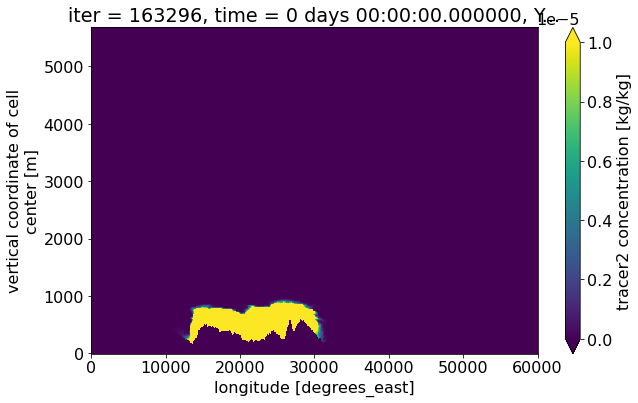

In [229]:
ds['TRAC01'].isel(time=-1).plot(cmap=cmap, vmin=0., vmax=1e-5)

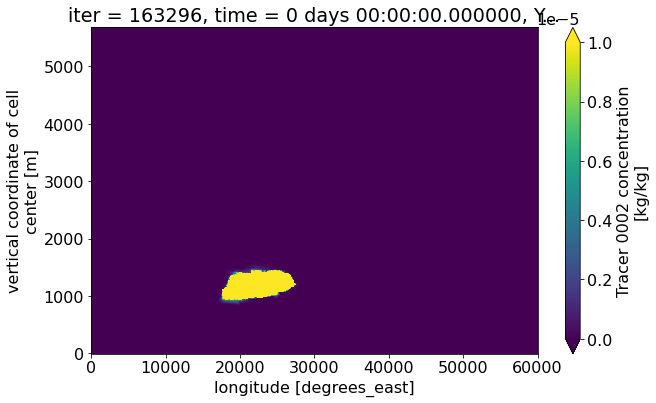

In [230]:
ds['TRAC02'].isel(time=-1).plot(cmap=cmap, vmin=0., vmax=1e-5)

### Reconstructing the full temperature field

In [231]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

### Tracer budgets

First, we evaluate the terms of the tracer and temperature budgets:
\begin{equation}
LHS = RHS = \text{Diffusion} + \text{Advection}
\end{equation}

In [232]:
for tr, tr_name in enumerate(["_TH", "Tr01", "Tr02"]):
    tmp = tracer_flux_budget(ds, grid, tr_name, θ=θ, Γ=Γ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
    if tr_name[0] != "_":
        tr_name = "_"+tr_name
    tmp[f'total_tendency{tr_name}'] = tmp[f'conv_total_flux{tr_name}'].fillna(0.)
    tmp[f'diff_tendency{tr_name}'] = tmp[f'conv_horiz_diff_flux{tr_name}'] + tmp[f'conv_vert_diff_flux{tr_name}']
    tmp[f'adv_tendency{tr_name}'] = tmp[f'conv_horiz_adv_flux{tr_name}'] + tmp[f'conv_vert_adv_flux{tr_name}']
    if tr_name == "_TH":
        tmp[f'adv_tendency{tr_name}'] = tmp[f'adv_tendency{tr_name}'] + tmp['conv_adv_flux_anom_TH']
        tmp[f'diff_tendency{tr_name}'] = tmp[f'diff_tendency{tr_name}'] + tmp['conv_vert_diff_flux_anom_TH']
        tmp[f'total_tendency_truth{tr_name}'] = ds.TOTTTEND * ds['dV'] * day2seconds
    else:
        tmp[f'total_tendency_truth{tr_name}'] = ds[f'Tp_g{tr_name[1:]}'] * ds['dV'] * day2seconds
    ds = xr.merge([ds, tmp])

## First moment budget (tracer-weighted mean temperature)


The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we compute this budget by explicitly reconstructing each of the following terms from the tracer and temperature budgets. Each term is diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed (this is not guaranteed since the buoyancy and tracer equations are solved separetly).

**Note:** Is hyperdiffusion included in the diffusive diagnostics?

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of just the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [233]:
tr = 1

### Tracer Mass

In [234]:
ds[f'M_Tr0{tr}'] = (ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()

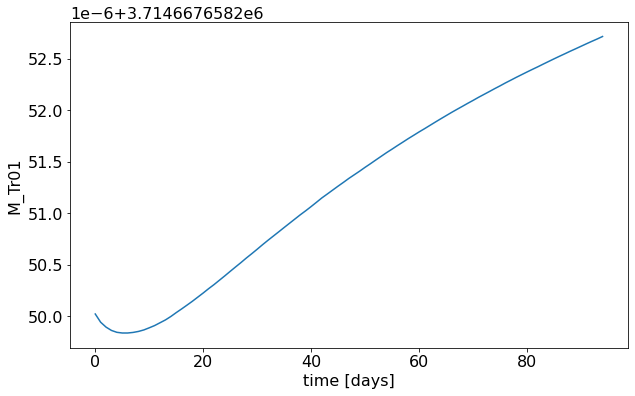

In [235]:
ds[f'M_Tr0{tr}'].plot()

### The LHS term

\begin{equation}
\text{LHS} = \int \left(c \partial_{t} \Theta + \Theta \partial_{t} c \right) \text{d}V
\end{equation}

In [236]:
ds[f'c_dθdt_Tr0{tr}'] = ds[f'TRAC0{tr}'] * (ds['TOTTTEND']* day2seconds) * ds['dV']
ds[f'θ_dcdt_Tr0{tr}'] = ds['θ'] * ds[f'Tp_gTr0{tr}'] * ds['dV']

ds[f'd(θbar)dt_Tr0{tr}'] = (
    (ds[f'c_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
    (ds[f'θ_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

### The RHS terms

#### The advective term

\begin{equation}
\int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V
\end{equation}

In [237]:
ds[f'c_div_uθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['adv_tendency_TH']
ds[f'θ_div_uc_Tr0{tr}'] = ds['θ']*ds[f'adv_tendency_Tr0{tr}']

ds[f'd(θbar)dt_ADV_Tr0{tr}'] = (
    (ds[f'c_div_uθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
    (ds[f'θ_div_uc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

#### The diffusive term

\begin{equation}
\int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) 
\end{equation}

In [238]:
ds[f'c_div_Fθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['diff_tendency_TH']
ds[f'θ_div_Fc_Tr0{tr}'] = ds['θ']*ds[f'diff_tendency_Tr0{tr}']

ds[f'd(θbar)dt_DIFF_Tr0{tr}'] = (
    (ds[f'c_div_Fθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() + 
    (ds[f'θ_div_Fc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


#### The sum of RHS terms

In [239]:
ds[f'd(θbar)dt_RHS_Tr0{tr}'] = ds[f'd(θbar)dt_DIFF_Tr0{tr}'] + ds[f'd(θbar)dt_ADV_Tr0{tr}']

#### The buoyancy velocity term

\begin{equation}
2\overline{\omega}
\end{equation}

In [240]:
ds[f'ωbar_Tr0{tr}'] = ((ds['diff_tendency_TH'] * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
ds[f'2ω_Tr0{tr}'] = 2*ds[f'ωbar_Tr0{tr}']

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


### Timeseries plot

Text(0.5, 1.0, 'Tidally-driven simulation (Tracer 1)')

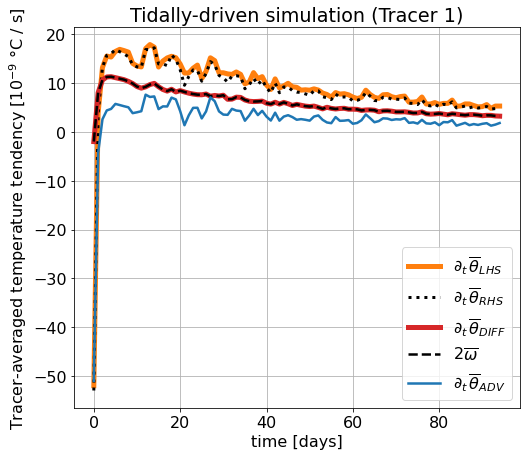

In [241]:
plt.figure(figsize=(8,7))
(1e9*ds[f'd(θbar)dt_Tr0{tr}']).plot(linestyle="-", color="C1", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
(1e9*ds[f'd(θbar)dt_RHS_Tr0{tr}']).plot(linestyle=":", color="k", lw=3, label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
(1e9*ds[f'd(θbar)dt_DIFF_Tr0{tr}']).plot(color="C3", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
(1e9*ds[f'2ω_Tr0{tr}']).plot(linestyle="--", color="k",lw=2.5, label=r"$2\overline{\omega}$")
(1e9*ds[f'd(θbar)dt_ADV_Tr0{tr}']).plot(color="C0", lw=2.5, linestyle="-", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
plt.legend()
plt.ylabel(r"Tracer-averaged temperature tendency [10$^{-9}$ $\degree$C / s]")
plt.grid(True)
plt.title(f"{explongname} (Tracer {tr})")

## Second moment budget (tracer-weighted centered temperature variance)